# SHAP

#### Import the libraries

In [9]:
import xgboost
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# load JS visualization code to notebook
shap.initjs()

#### Read the data

In [11]:
# read the data
df = pd.read_csv('../experiments/total.csv', index_col=0)

In [12]:
# mylyn
#df = x[['linesAddedUntil', 'ageWithRespectTo', 'weightedAgeWithRespectTo', 'numberOfPrivateMethods', 'bugs_classification']].copy()
# pde
#df = df[['ageWithRespectTo', 'CvsEntropy', 'dit', 'numberOfAttributes', 'bugs_classification']].copy()
# lucene
#df = x[['codeChurnUntil', 'CvsExpEntropy', 'bugs_classification']].copy()

#### Normalize the dataset

In [13]:
# delete unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# convert all columns of DataFrame
df = df.dropna()
# find the objects columns
cols = df.columns[df.dtypes.eq('object')]
# convert to numeric these columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [14]:
df.shape

(80044, 20)

#### Separate the data

In [15]:
# separating X and y
cols = [col for col in df.columns if col not in ['bug']]
X = df[cols]

In [16]:
# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [17]:
# explain the model's predictions using SHAP values.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [18]:
#shap.force_plot(explainer.expected_value, shap_values, X, link='identity')

In [19]:
#shap.save_html('../reports/jdt_force.html', shap.force_plot(explainer.expected_value, shap_values, X))

#### Summary plot

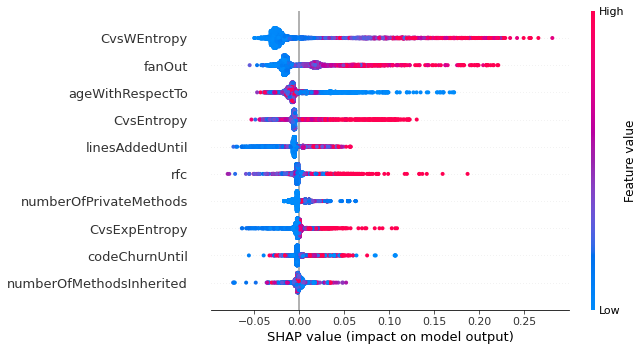

In [149]:
shap.summary_plot(shap_values, X, max_display=10, show=False)
#plt.savefig('../reports/lucene-summary.png',bbox_inches='tight')

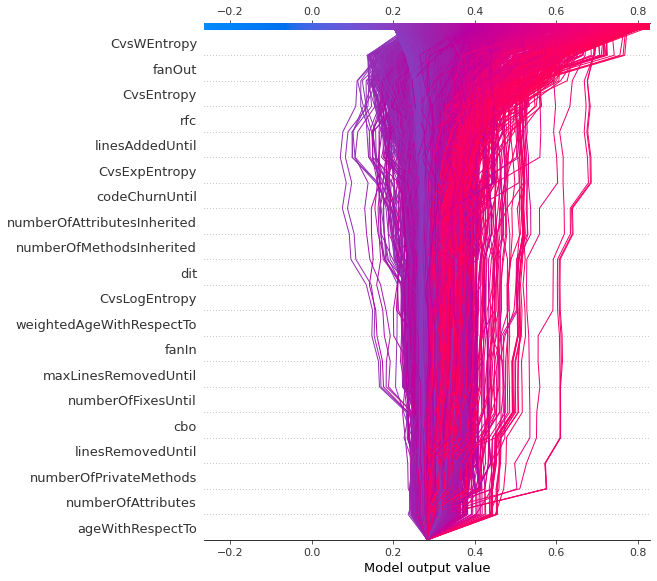

In [150]:
shap.decision_plot(
    explainer.expected_value,
    shap_values,
    X,
    feature_display_range=slice(None, -200, -1),
    link='identity',
    feature_order='hclust',
    feature_names=WANTED_COLUMNS,
    #show=False,
    ignore_warnings=True
)

#### Local Explanation

In [163]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

In [164]:
shap.force_plot(explainer.expected_value, shap_values[31,:], X.iloc[31,:])

#### Bar Plot

In [25]:
shap_v = pd.DataFrame(shap_values)
feature_list = X.columns
shap_v.columns = feature_list
df_v = X.copy()#.reset_index().drop('index',axis=1)
    
# Determine the correlation in order to plot with different colors
corr_list = list()
for i in feature_list:
    b = np.corrcoef(shap_v[i],df_v[i])[1][0]
    corr_list.append(b)

In [26]:
corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
# Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
corr_df.columns  = ['Feature','Corr']
corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

In [27]:
# Plot it
shap_abs = np.abs(shap_v)
k=pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Feature','SHAP_abs']
k2 = k.merge(corr_df,left_on = 'Feature',right_on='Feature',how='inner')
k2 = k2.sort_values(by='SHAP_abs',ascending = True)
k3 = k2.tail(10)
colorlist = k3['Sign']

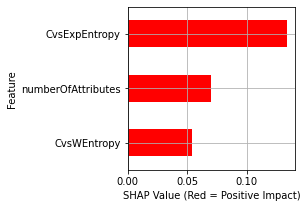

In [28]:
ax = k3.plot.barh(x='Feature',y='SHAP_abs',color = colorlist, figsize=(3,3),legend=False)
ax.set_xlabel("SHAP Value (Red = Positive Impact)")
ax.grid()
plt.savefig('../reports/jdt.png',dpi=300,bbox_inches='tight')

#### SNS Plot

#### That's all folks!!!